# Goal of this python notebook

In this python notebook, we see that a DL model is able to predict $ λ$ , which characterizes the metric of 2+1 AdS, $$ ds^2 = -(1+λ^2 r^2)dt^2 + \frac{dr^2}{1+ λ^2 r^2} + dϕ^2,
$$ by a simulation using $(x, y)$ images of  free particles geodesics, where $x = r \cos \phi$ and $y = r \sin \phi$.

# Import library

We first import some libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import  Conv2D
from keras.layers.pooling import  MaxPooling2D
from skimage.color import gray2rgb

# Mounting the google drive

To save the dataset we will generate, we utilize the google drive in this notebook. So we have to mount the google drive.

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Generate data

We first generate $(x,y)$ images of geodesics using the solution of the equation of motion of free particles in 2+1 AdS,
$$ r = \frac{1}{λ} \sqrt{E - \sqrt{E^2 - λ^2 L^2} \sin2 λ \tau},$$
$$\phi = \pm \arctan \left[  \frac{E}{\lambda L} \left( \tan λ \tau - \sqrt{1 - \left( \frac{λ L }{E}\right)^2} \right)\right] + \phi_0, $$
$$ t = \frac{1}{\lambda} \arctan \left[ \frac{(1+E)\tanλ\tau - \sqrt{E^2 - λ^2 L^2}}{\sqrt{1+2E+λ^2 L^2}} \right] + t_0 ,$$
where $E$  is a positive constant associated with energy, $L$ is a real constant associated with angular momentum, and
$t_0$ $(ϕ_0)$ is an integration constant for $t (ϕ )$.

We generate $\lambda$, $E$, $L$, $t_0$ and $\phi_0$ at random. We set the range of them to 
$ 0 \leq E < 10$, $0 \leq L < \frac{E}{λ}$ , $ 0 \leq \phi_0 <2 \pi$ and $ 0 \leq t_0 <2 \pi$. 
The value of $λ$ is chosen as an integer between 1 and 4 for simplity.

In [4]:
def generate_initial_state(num_particle):
  # num_particle means the number of particles/trajectories in one image.

  # lambda_rand means the value of lambda in 2+1 AdS metric.
  lambda_rand  = np.random.randint(1,5) # 1 <= \lambda <5 to avoid singularity 

  E_rand = np.random.rand(num_particle)*10 # E_rand represents E.
  L_rand =  np.random.rand(num_particle)* E_rand / lambda_rand # L_rand represents L.
  phi_rand = np.random.rand(num_particle)* 2 *np.pi - np.pi #phi_rand represents \phi_0.
  
  return E_rand,L_rand,phi_rand,lambda_rand

We calculate the geodesic of one particle using the solution of the equation of motion. 

In [5]:
def time_evolve(t,E,L,lambda0,phi0):
  r = 1 / lambda0 *  np.sqrt(E - np.sqrt(E ** 2 - (lambda0 ** 2) * (L ** 2) ) * np.sin(2 * lambda0 * t) )

  Y = E * (np.tan(lambda0 * t) - np.sqrt(1- (lambda0 * L / E)**2 ) )
  X = lambda0 * L
  phi = np.arctan2(Y,X) + phi0
  return r,phi

We make numpy arrays which are utilized to get one image.

In [6]:
def generate_xy2_one_data(num_particle):

  delta_t = 0.005 #delta_t represents the slice of \tau.

  # Because \tau is the argument of trigonometric functions sin(2 \lambda \tau) and tan(\lambda \tau), we can set the range of $\tau$ to $ 0 \leq \tau < \pi.
  time_frame = int(np.ceil(np.pi / delta_t)) # tau_frame is the number of frames.

  # setting the number of pixels in a image.
  pixel_num = 200
  
  # setting the width and height of images. 10 comes from the maximum value of E we set.
  h = 10
  
  #delta_xy represents the slice of images.
  delta_xy = h/pixel_num 

  E_rand, L_rand,phi_rand,lambda_rand = generate_initial_state(num_particle)
  
  #\phi has a freedom of sign and we assign the sign by binomial random variables. 
  sign = np.random.binomial(1,0.5,size=num_particle)
 

  temp = []
  # obtaining (x,y) arrays from  (r,\phi) arrays.
  for i in range(0,time_frame): 
    # i is the counter for the frame number.

      for j in range(num_particle):
        # j is the counter for the particle number.

        r,phi = time_evolve(i * delta_t, E_rand[j],L_rand[j],lambda_rand,phi_rand[j])
        x = ((-1) ** sign[j]  )   * r * np.cos(phi)
        y =  r * np.sin(phi)

        # discretizing x and y by delta_xy. h/2 is the origin of the plot
        temp.append( [int(np.floor((x+h/2)/delta_xy)), int(np.floor((y+h/2)/delta_xy))])
        temp.append( [int(np.floor((-x+h/2)/delta_xy)), int(np.floor((-y+h/2)/delta_xy))])

  xy_image = np.zeros([pixel_num, pixel_num,1])
  for item in temp:
      x = int(item[0])
      y = int(item[1])
      xy_image[x,y,0] = 1
  
  return xy_image,lambda_rand

We make $(x, y)$ image dataset using generate_xy2_one_data function we defined.

In [7]:
def generate_xy2_data(num_data,num_particle):
  data_x = [] # to save xy images
  data_y = [] # to save lambda values
  for i in range(num_data):
    x,y = generate_xy2_one_data(num_particle)
    data_x.append(x)
    data_y.append(y)

  return data_x,data_y

We set num_particle = 10  and num_data = 2000 and generate dataset  using functions we defined above.

In [8]:
# setting parameters
num_particle = 10
num_learning_data = 2000 #should be multiple of 2000

# generating 1400 training data, 400 validation data and 200 test data.
x_train,y_train = generate_xy2_data(int(0.7*num_learning_data),num_particle)
x_vali,y_vali = generate_xy2_data(int(0.2*num_learning_data),num_particle)
x_test,y_test = generate_xy2_data(int(0.1*num_learning_data),num_particle)

x_train = np.array(x_train)
x_vali = np.array(x_vali)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_vali = np.array(y_vali)
y_test = np.array(y_test)

We save the dataset numpy array in the google drive. Note that you may have to replace the file path which shows where the dataset array is saved, according to your folder structure. 

In [9]:
# saving the data in npz file
# replacing the file path accodring to your coding environment.
file_path = "/content/drive/My Drive/Colab Notebooks/metric_detecter_public"
# You can replace the  "/3d_raw_array" to your favorite name of npz file.
np.savez_compressed(file_path + '/dataset_array_xy', x_train, y_train,x_vali,y_vali,x_test,y_test)

# Printing some images and Preprocessing

We perform some preprocessing and print some $(x,y)$ images.

In [11]:
#reloading the data from npz file
#replacing the file path accodring to your coding environment.
file_path = "/content/drive/My Drive/Colab Notebooks/metric_detecter_public"
dataset_array = np.load(file_path + '/dataset_array_xy.npz')
x_train = dataset_array["arr_0"]
y_train = dataset_array["arr_1"]
x_vali = dataset_array["arr_2"]
y_vali = dataset_array["arr_3"]
x_test = dataset_array["arr_4"]
y_test = dataset_array["arr_5"]

In [12]:
# converting target labels to one-hot vectors
y_train_one_hot = np_utils.to_categorical(y_train-1)
y_vali_one_hot = np_utils.to_categorical(y_vali-1)
y_test_one_hot = np_utils.to_categorical(y_test-1)

In [13]:
# converting dataset to black and white images
x_train= gray2rgb(x_train[:,:,:,0])
x_vali= gray2rgb(x_vali[:,:,:,0])
x_test= gray2rgb(x_test[:,:,:,0])

value of lambda: 3


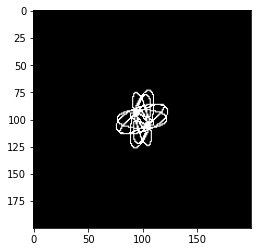

value of lambda: 4


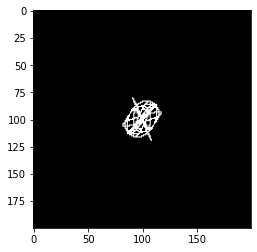

value of lambda: 4


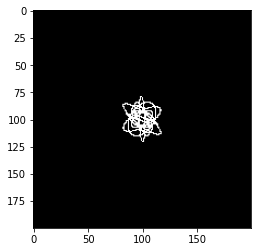

value of lambda: 1


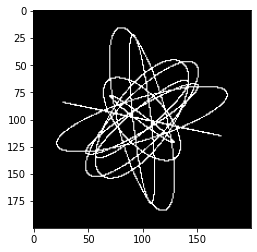

In [14]:
# printing some examples of images
for i in range(4):
  plt.imshow(x_train[i][:,:])
  
  print("value of lambda:",y_train[i])
  plt.show()

# Training a DL model

Here, we train a DL model.  We use CNN. It's structure is the following.

In [15]:
input_shape = x_train[0,:,:,:].shape
model = Sequential()
model.add(Conv2D(5, (5,5), strides=(1, 1), input_shape=input_shape,padding='same', dilation_rate=(1, 1),activation='tanh', use_bias=True))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Conv2D(5, (5,5), strides=(1, 1),padding='same',activation='tanh', use_bias=True))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Conv2D(5, (3,3), strides=(1, 1),padding='same',activation='tanh', use_bias=True))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Conv2D(3, (3,3), strides=(1, 1),padding='same',activation='tanh', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(2, (2,2), strides=(1, 1),padding='same',activation='tanh', use_bias=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(10,activation='tanh'))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 5)       380       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 67, 67, 5)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 5)         630       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 5)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 5)         230       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 5)          0

The loss function of this task is the categorical crossentropy and we use ADAM as a optimizer. We train the model for 150 epochs.

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train_one_hot,
                    batch_size=50,
                    epochs=150,
                    verbose=1,
                    validation_data=(x_vali, y_vali_one_hot))
score = model.evaluate(x_test, y_test_one_hot, verbose=0)

Epoch 1/150
14/14 [==============================] - 13s 50ms/step - loss: 1.3770 - accuracy: 0.2471 - val_loss: 1.3360 - val_accuracy: 0.4050
Epoch 2/150
14/14 [==============================] - 0s 25ms/step - loss: 1.3202 - accuracy: 0.3971 - val_loss: 1.2613 - val_accuracy: 0.5650
Epoch 3/150
14/14 [==============================] - 0s 24ms/step - loss: 1.2380 - accuracy: 0.4871 - val_loss: 1.1552 - val_accuracy: 0.6900
Epoch 4/150
14/14 [==============================] - 0s 25ms/step - loss: 1.1368 - accuracy: 0.6029 - val_loss: 1.0244 - val_accuracy: 0.7500
Epoch 5/150
14/14 [==============================] - 0s 24ms/step - loss: 1.0042 - accuracy: 0.7029 - val_loss: 0.8690 - val_accuracy: 0.8100
Epoch 6/150
14/14 [==============================] - 0s 24ms/step - loss: 0.8773 - accuracy: 0.7671 - val_loss: 0.7140 - val_accuracy: 0.8900
Epoch 7/150
14/14 [==============================] - 0s 23ms/step - loss: 0.7480 - accuracy: 0.8114 - val_loss: 0.5770 - val_accuracy: 0.9400
Epoch

We check the value of the loss function for test data and plot how loss functions for training data and validation data change as the model learnes.

The loss function for test data: 0.025739474222064018


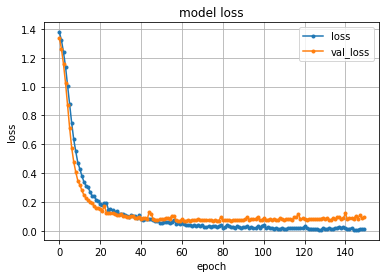

In [17]:
print('The loss function for test data:', score[0])
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

We also check how the model accuracy varies.

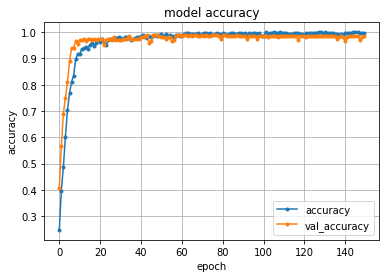

In [18]:
plt.plot(history.history['accuracy'], marker='.', label='accuracy')
plt.plot(history.history['val_accuracy'], marker='.', label='val_accuracy')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

We see the model accuracy for test data. 

In [19]:
print('The accuracy for test data:', score[1])

The accuracy for test data: 0.9900000095367432


Let's print some results of the predicting of DL. The title of each image shows the prediction and the blue (red) color of the title means the correct (incorrect) prediction. DL returns right answers for almost all images.

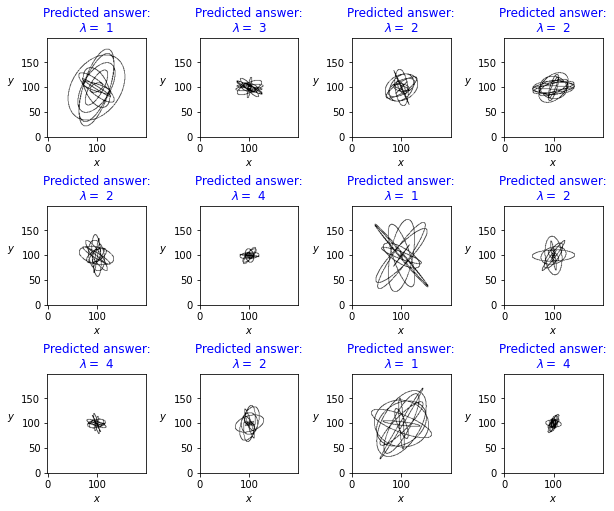

In [20]:
# calculating the prediction for test data
y_pred_one_hot = model.predict(x_test)
max_pred_index = np.argmax(y_pred_one_hot, axis=1)
max_test_index = np.argmax(y_test_one_hot, axis=1)

# showing some images with predicted values
num_rows = 3
num_cols = 4
plt.figure(figsize=(10,8))
plt.subplots_adjust( wspace = 0.5,hspace=0.7)

k = 0
plot_index = 1
for i in range(num_rows):
  for j in range(num_cols):
    plt.subplot(num_rows,num_cols,plot_index)
     
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$",rotation = "horizontal",labelpad=10)
    plt.imshow(x_test[k,:,:,0].reshape(200,200), cmap=plt.cm.gray_r,origin='lower') 
    if max_pred_index[k] == max_test_index[k]:
      title_color = "blue"
    else:
      title_color = "red"
    plt.title(f"Predicted answer:\n"r"$\lambda= $"f" {y_test[k]}",color=title_color)
    k += 1
    plot_index += 1